In [3]:
import sys
sys.path.append("./simulation/")

#from util import *
import os, shutil
import pandas as pd
from datetime import datetime

from opmap.cmap import bipolar
from opmap.videoData import VideoData
from opmap.vmemMap import VmemMap
from opmap.phaseMap import PhaseMap
from opmap.phaseMapHilbert import PhaseMapHilbert
from opmap.phaseMapFTDT import PhaseMapFTDT
from opmap.phaseVarianceMap import PhaseVarianceMap
from opmap.phaseMapEvent import PhaseMapEvent
from opmap.f_pixel import f_pixel_diff_thre
from opmap.util import phaseComplement


from elecpy.elecpySession import ElecpySession

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.path as mpath
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import art3d
from matplotlib import cm
import copy

import math

%matplotlib inline


from opmap.util import phaseComplement

In [8]:
import scipy

In [4]:
src_dir = '/mnt/Omer/Project/01.PhaseDiscontinuity/SimulationResults/'
save_dir = '/mnt/Shelter/Project/01.PhaseDiscontinuity/AnalysisResults/2019-12-07/'
print(save_dir)
if not os.path.exists(save_dir) : os.mkdir(save_dir)

/mnt/Shelter/Project/01.PhaseDiscontinuity/AnalysisResults/2019-12-07/


In [5]:
def analyzeSession(sess, save_dir=None):
    
    vmem = VideoData(*sess.data['vmem'].shape)
    vmem.data = sess.data['vmem']
    vmem.cmap = bipolar(neutral=0, lutsize=1024)
    vmem.vmin = sess.data['vmem'].min()
    vmem.vmax = sess.data['vmem'].max()
    
    p_hilbert = PhaseMapHilbert(vmem, width = vmem.data.shape[2], sigma_xy=1, sigma_t=1);
    sess.data['p_hilbert'] = p_hilbert.data
            

In [17]:
def phaseComplement(value):
    value -= (value > np.pi)*2*np.pi
    value += (value < - np.pi)*2*np.pi
    return value

def topologic_charge(P):
    P_dx = np.zeros_like(P)
    P_dy = np.zeros_like(P)
    P_dx[:, :-1] = phaseComplement(P[:,1:] - P[:,:-1])
    P_dy[:-1,:] = phaseComplement(P[1:,:] - P[:-1,:])

    filter_dx = [[1,1],[0,0],[-1,-1]]
    filter_dy = [[-1,0,1], [-1,0,1]]

    integ_dx = scipy.signal.convolve2d(P_dx, filter_dx, mode='same', boundary='symm')
    integ_dy = scipy.signal.convolve2d(P_dy, filter_dy, mode='same', boundary='symm')
    return np.abs(integ_dx+integ_dy)/2*np.pi

def phase_variance(P):
    im_cos = np.cos(P)
    im_sin = np.sin(P)
    f = np.ones((3,3))
    f /= np.sum(f)
    im_cos = scipy.signal.convolve2d(im_cos, f, mode='same', boundary='symm')
    im_sin = scipy.signal.convolve2d(im_sin, f, mode='same', boundary='symm')
    im_pv = 1-np.abs(im_cos+1j*im_sin)
    return im_pv

## Toplogic chargeの評価

In [74]:
df_region = pd.read_csv('data.roi.csv')
df_region

,sim_id,x_min,x_max,y_min,y_max,f_min,f_max,result_id,description
0,20190226-3,130,170,120,160,1700,1740,A,pinning
1,20180625-1,110,150,80,120,120,160,C,meandering
2,20180625-1,160,200,80,120,225,265,D,spiral stop
3,20180616-1,80,120,80,120,360,400,B,over the trajectory of vortex shedding


In [75]:
df_region.at[2,"x_min"] = 140
df_region.at[2,"x_max"] = 200
df_region.at[2,"y_min"] = 70
df_region.at[2,"y_max"] = 130

df_region.at[3,"x_min"] = 70
df_region.at[3,"x_max"] = 130
df_region.at[3,"y_min"] = 70
df_region.at[3,"y_max"] = 130

df_region

,sim_id,x_min,x_max,y_min,y_max,f_min,f_max,result_id,description
0,20190226-3,130,170,120,160,1700,1740,A,pinning
1,20180625-1,110,150,80,120,120,160,C,meandering
2,20180625-1,140,200,70,130,225,265,D,spiral stop
3,20180616-1,70,130,70,130,360,400,B,over the trajectory of vortex shedding


/mnt/Shelter/Project/01.PhaseDiscontinuity/AnalysisResults/2019-12-07/20180625-1
/mnt/Omer/Project/01.PhaseDiscontinuity/SimulationResults/20180625-1
225ms


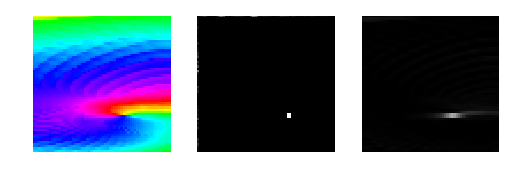

226ms


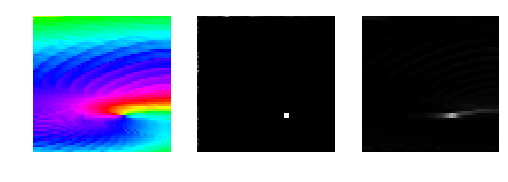

227ms


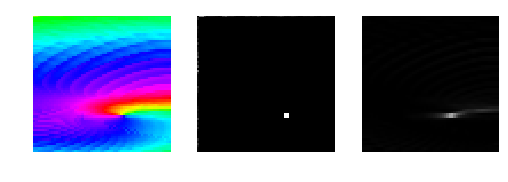

228ms


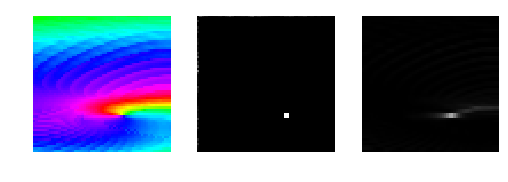

229ms


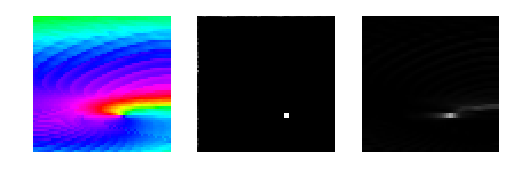

230ms


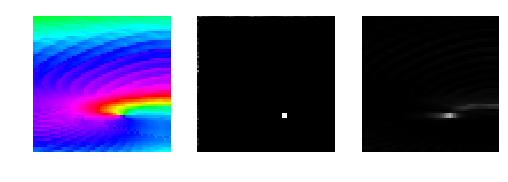

231ms


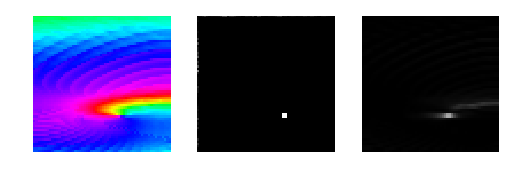

232ms


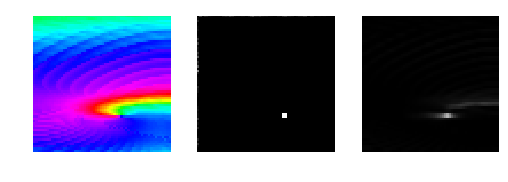

233ms


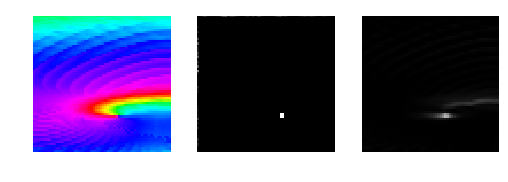

234ms


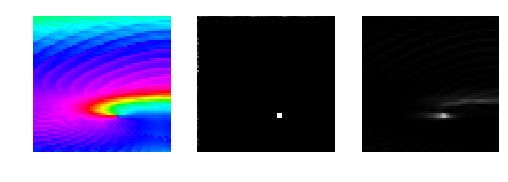

235ms


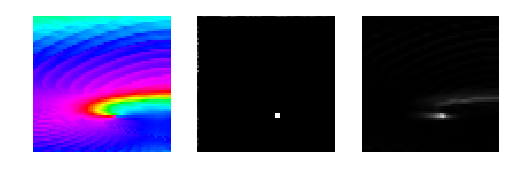

236ms


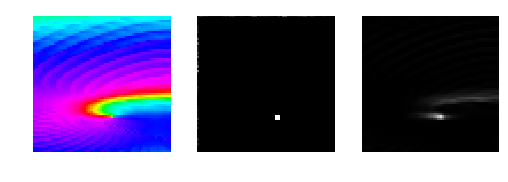

237ms


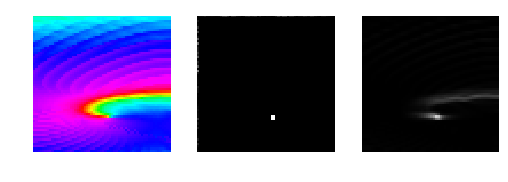

238ms


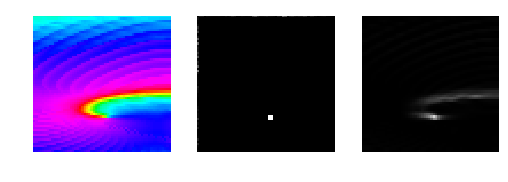

239ms


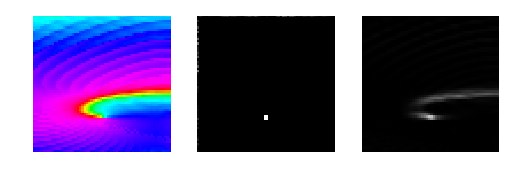

240ms


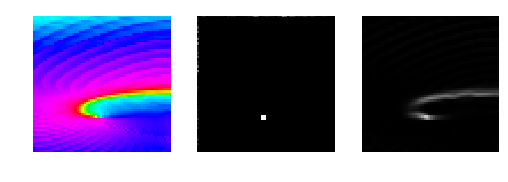

241ms


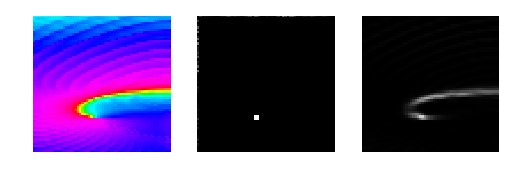

242ms


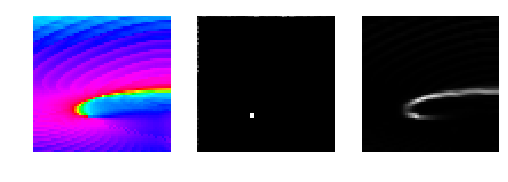

243ms


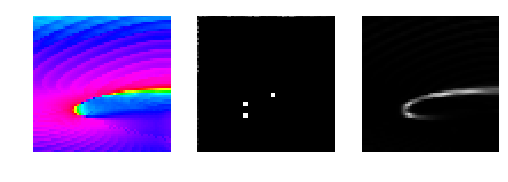

244ms


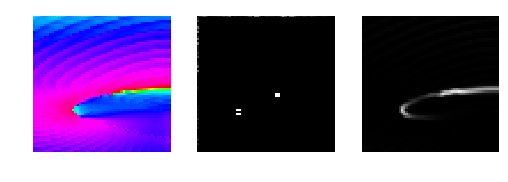

245ms


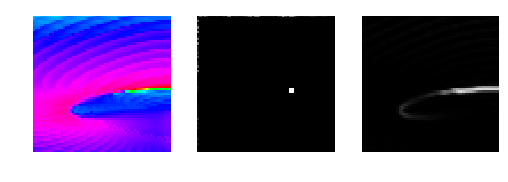

246ms


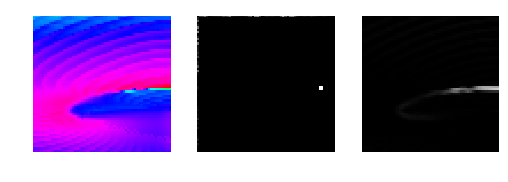

247ms


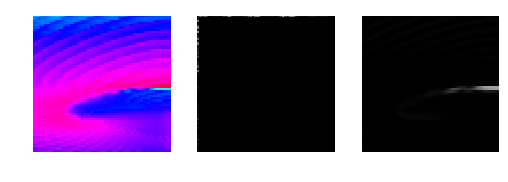

248ms


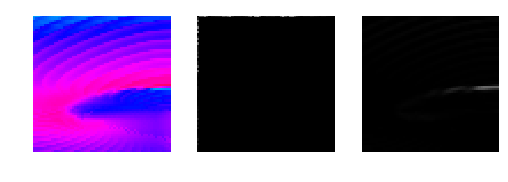

249ms


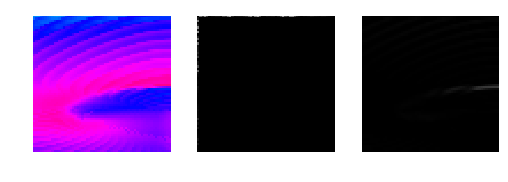

250ms


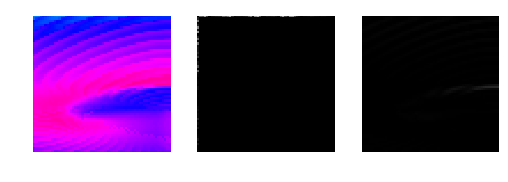

251ms


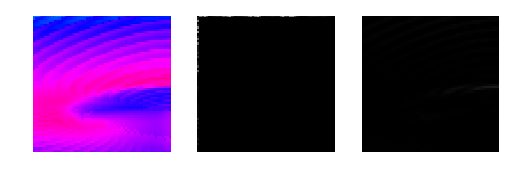

252ms


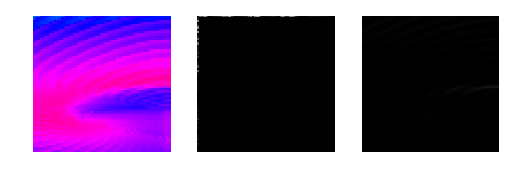

253ms


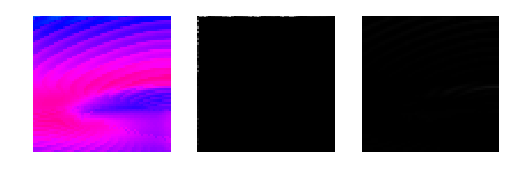

254ms


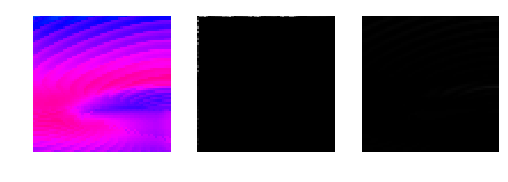

255ms


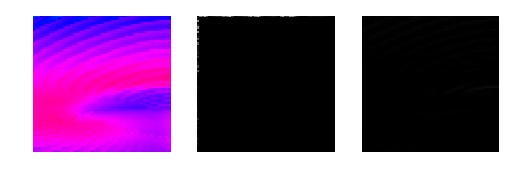

256ms


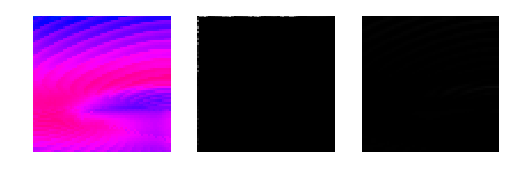

257ms


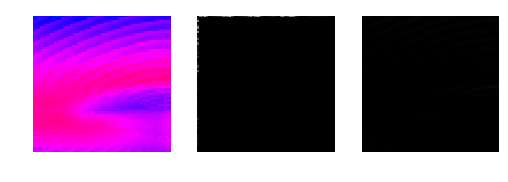

258ms


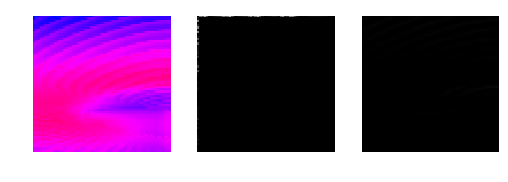

259ms


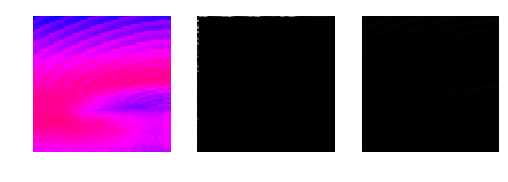

260ms


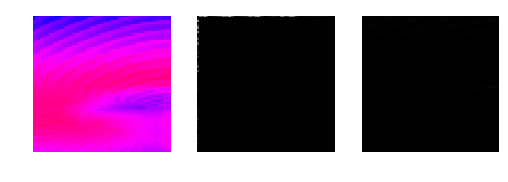

261ms


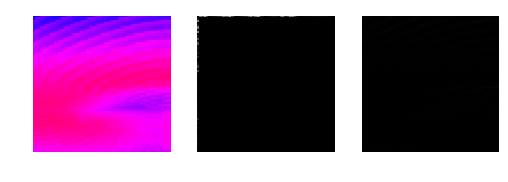

262ms


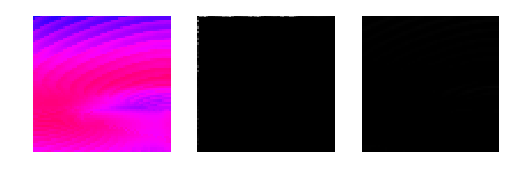

263ms


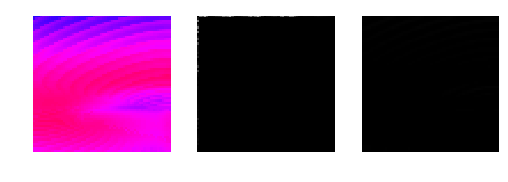

264ms


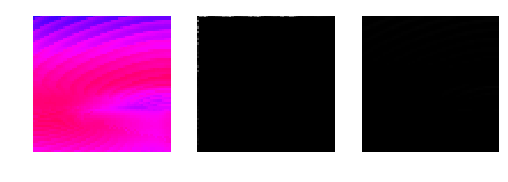

/mnt/Shelter/Project/01.PhaseDiscontinuity/AnalysisResults/2019-12-07/20180616-1
/mnt/Omer/Project/01.PhaseDiscontinuity/SimulationResults/20180616-1
360ms


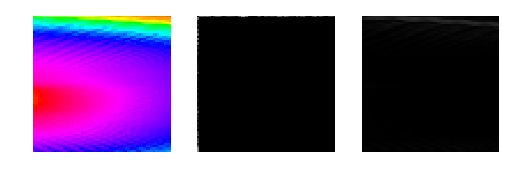

361ms


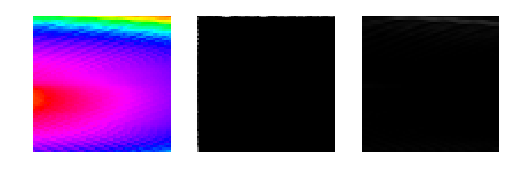

362ms


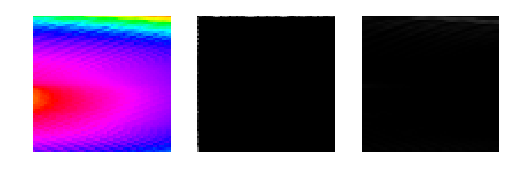

363ms


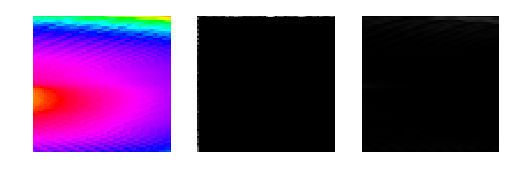

364ms


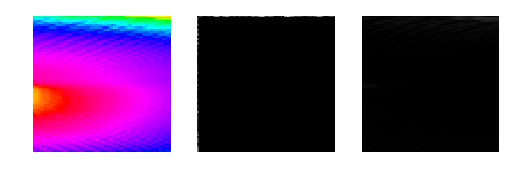

365ms


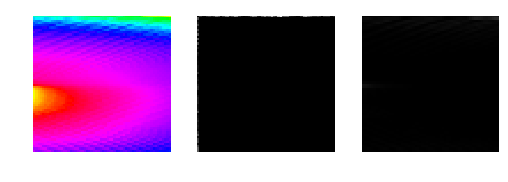

366ms


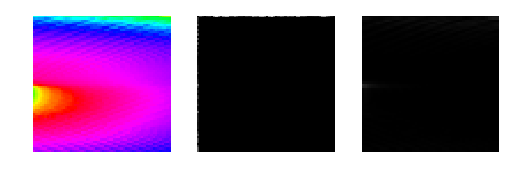

367ms


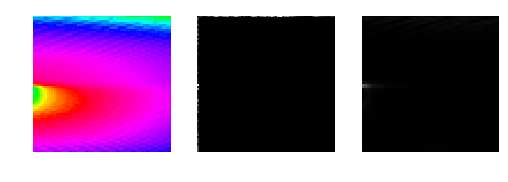

368ms


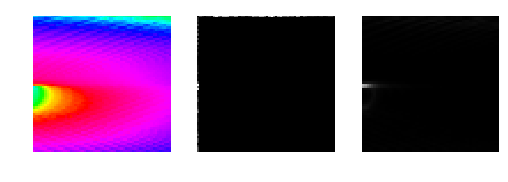

369ms


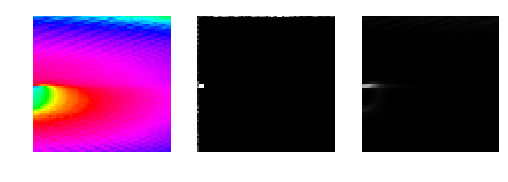

370ms


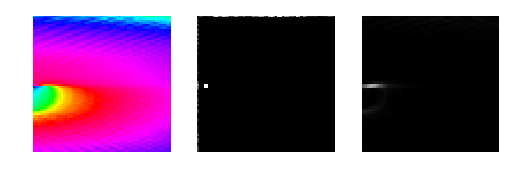

371ms


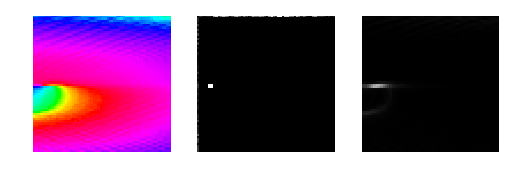

372ms


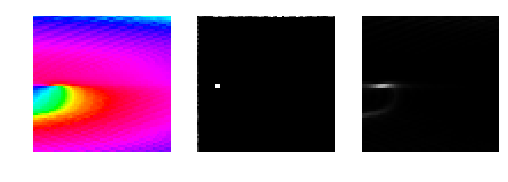

373ms


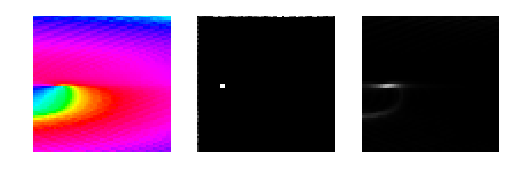

374ms


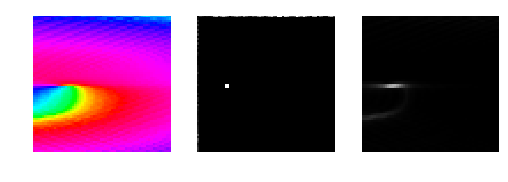

375ms


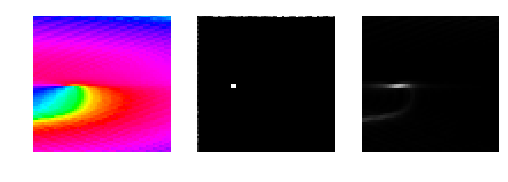

376ms


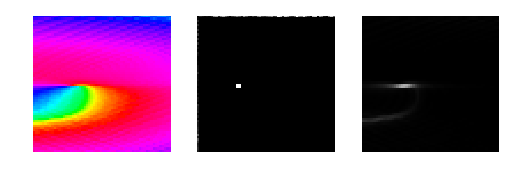

377ms


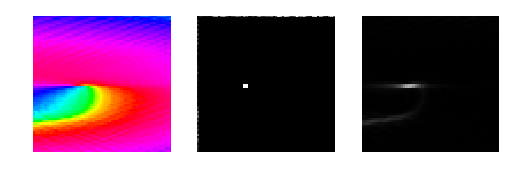

378ms


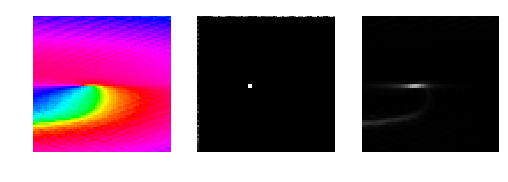

379ms


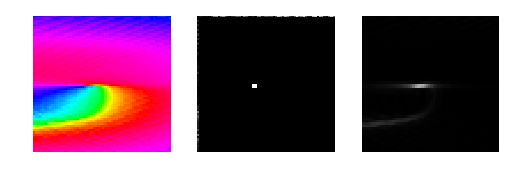

380ms


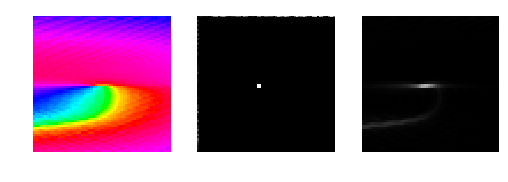

381ms


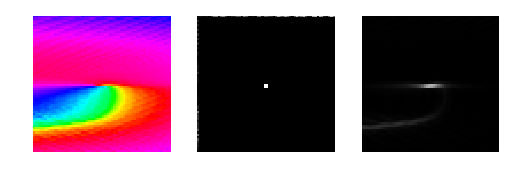

382ms


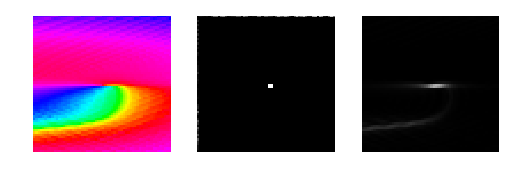

383ms


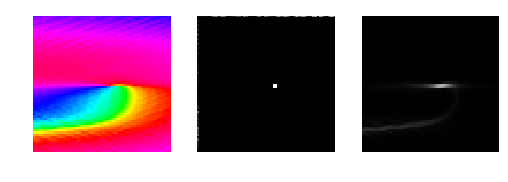

384ms


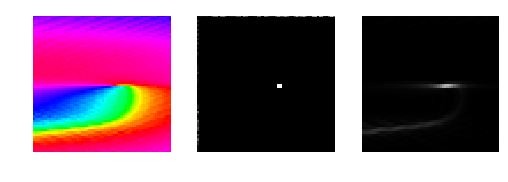

385ms


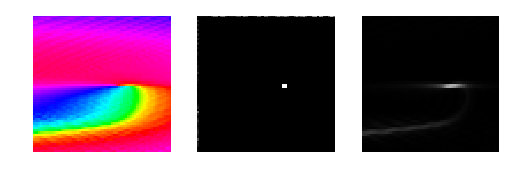

386ms


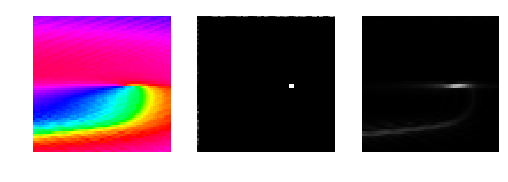

387ms


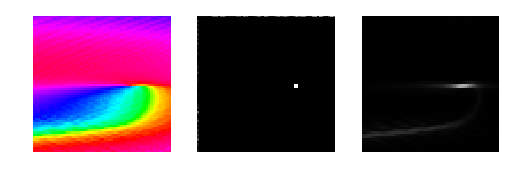

388ms


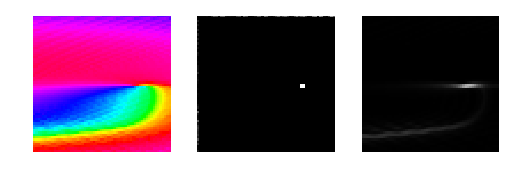

389ms


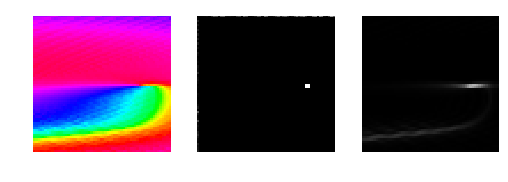

390ms


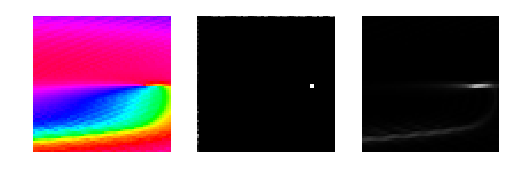

391ms


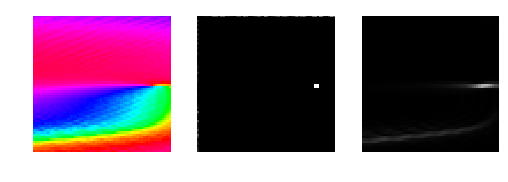

392ms


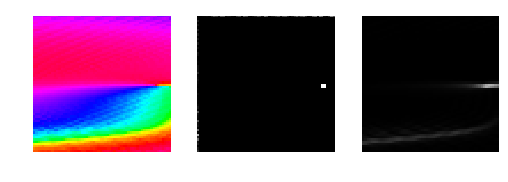

393ms


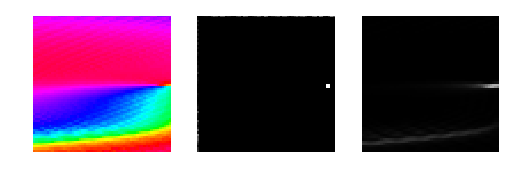

394ms


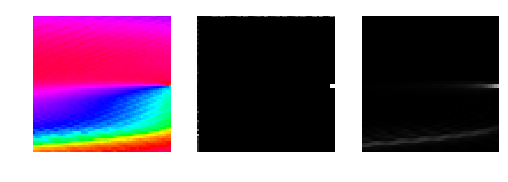

395ms


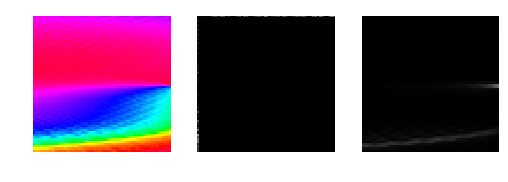

396ms


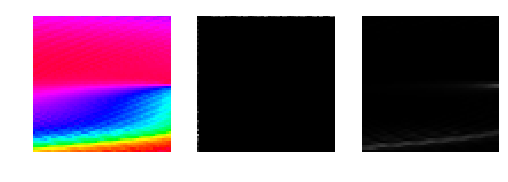

397ms


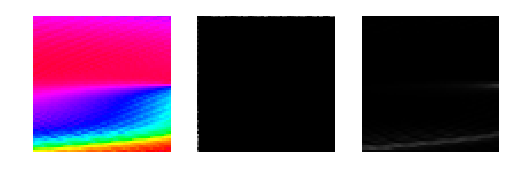

398ms


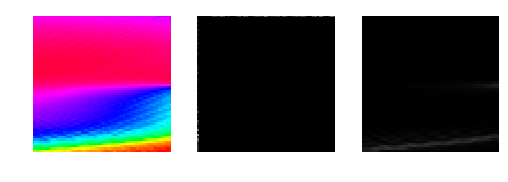

399ms


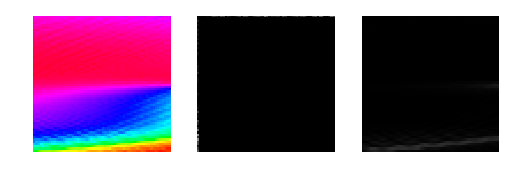

In [76]:
for i, row in df_region.iterrows():
    
    if i not in [2,3]: continue
    
    dst_dir = os.path.join(save_dir, '{0}'.format(row['sim_id']))
    print(dst_dir)
    if not os.path.exists(dst_dir) : os.makedirs(dst_dir)        
    print(os.path.join(src_dir, row.sim_id))
    
    sess = ElecpySession( os.path.join(src_dir, row.sim_id), keys=['vmem'])
    analyzeSession(sess)
        
    for i, f in enumerate(range(row.f_min, row.f_max)):
        print('{0}ms'.format(f))

        P = sess.data['p_hilbert'][f, row.y_min:row.y_max, row.x_min:row.x_max]
        
        options = {'interpolation':'nearest', 'vmax':np.pi, 'vmin':-np.pi, 'cmap':'hsv'}
        fig=plt.figure()
        plt.subplot(131)
        plt.imshow(P, **options)
        plt.axis('off')
        plt.subplot(132)
        options['cmap'] = 'gray'
        options['vmin'] = 0
        options['vmax'] = 1
        plt.imshow(topologic_charge(P), **options)
        plt.axis('off')
        plt.subplot(133)
        plt.imshow(phase_variance(P), **options)
        plt.axis('off')
        plt.savefig(os.path.join(dst_dir, '{0:0>6}.png'.format(i)))
        plt.show()
    

In [39]:
def makeMovie(path, img_type='png'):

    cmd = 'ffmpeg -r 15 -y -i "{0}/%06d.{1}" -vcodec rawvideo "{0}.avi"'.format(path, img_type)
    print(cmd)
    os.system(cmd)

In [77]:
makeMovie(dst_dir)

ffmpeg -r 15 -y -i "/mnt/Shelter/Project/01.PhaseDiscontinuity/AnalysisResults/2019-12-07/20180616-1/%06d.png" -vcodec rawvideo "/mnt/Shelter/Project/01.PhaseDiscontinuity/AnalysisResults/2019-12-07/20180616-1.avi"


In [78]:
!ffmpeg -r 15 -y -i "/mnt/Shelter/Project/01.PhaseDiscontinuity/AnalysisResults/2019-12-07/20180625-1/%06d.png" -vcodec rawvideo "/mnt/Shelter/Project/01.PhaseDiscontinuity/AnalysisResults/2019-12-07/20180625-1.avi"

ffmpeg version 2.8.15-0ubuntu0.16.04.1 Copyright (c) 2000-2018 the FFmpeg developers
  built with gcc 5.4.0 (Ubuntu 5.4.0-6ubuntu1~16.04.10) 20160609
  configuration: --prefix=/usr --extra-version=0ubuntu0.16.04.1 --build-suffix=-ffmpeg --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --cc=cc --cxx=g++ --enable-gpl --enable-shared --disable-stripping --disable-decoder=libopenjpeg --disable-decoder=libschroedinger --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libopenjpeg --enable-libopus --enable-libpulse --enable-librtmp --enable-libschroedinger --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --

## 連続性を仮定したinterpolationの問題点

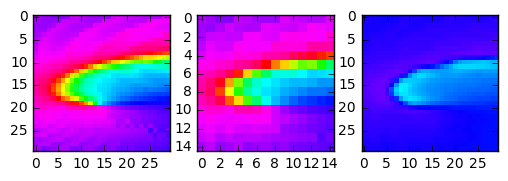

In [20]:
P = sess.data['p_hilbert'][240, 95:125, 155:185]
k=2

im_cos = np.cos(P[::k,::k]) 
im_sin = np.sin(P[::k,::k])
im_cos = scipy.misc.imresize(im_cos, P.shape, interp='bilinear')
im_sin = scipy.misc.imresize(im_sin, P.shape, interp='bilinear')

P_inter = np.angle(im_cos+1j*im_sin)

options = {'interpolation':'nearest', 'vmax':np.pi, 'vmin':-np.pi, 'cmap':'hsv'}
plt.subplot(131)
#plt.imshow(np.cos(P), interpolation='nearest')
plt.imshow(P, **options)
plt.subplot(132)
plt.imshow(P[::k,::k], **options)
plt.subplot(133)
plt.imshow(P_inter, **options)
plt.show()